# LSTM (RNN) - ETH

### Importing Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
plt.style.use("ggplot")

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

### Loading the Data

In [3]:
df = pd.read_excel('data/eth_api_data_use.xlsx')

In [5]:
df.set_index('t', inplace=True)

In [7]:
df

,count,sending_count,receiving_count,active_count,new_non_zero_count,block_height,sopr,price_usd_close,marketcap_usd,difficulty_latest,hash_rate_mean
t,,,,,,,,,,,
2015-08-08,10641,582,439,800,353,55869,0.459823,0.769981,8.983510e+07,1606016380751,9.644985e+10
2015-08-09,10894,457,489,731,253,60992,0.403942,0.719830,5.507245e+07,1741399466631,1.013969e+11
2015-08-10,11543,804,749,997,649,66247,0.360587,0.700705,4.878861e+07,1948102094734,1.116431e+11
2015-08-11,13432,2119,2106,2339,1889,71527,0.614763,1.088361,5.745360e+07,2171897473895,1.240757e+11
2015-08-12,13744,565,673,904,312,76651,0.609176,1.214071,8.079017e+07,2248237602936,1.308930e+11
...,...,...,...,...,...,...,...,...,...,...,...
2021-08-29,126646738,216340,261453,443638,81015,13123511,1.038184,3232.684457,3.771270e+11,8344135842611030,6.156244e+14
2021-08-30,126736492,216528,279101,463898,89754,13129983,1.054713,3236.705129,3.779495e+11,8363391489903990,6.243794e+14
2021-08-31,126832691,232263,294382,489456,96199,13136426,1.068187,3440.253672,3.918475e+11,8409844260273910,6.290792e+14


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2214 entries, 2015-08-08 to 2021-09-02
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   count               2214 non-null   int64  
 1   sending_count       2214 non-null   int64  
 2   receiving_count     2214 non-null   int64  
 3   active_count        2214 non-null   int64  
 4   new_non_zero_count  2214 non-null   int64  
 5   block_height        2214 non-null   int64  
 6   sopr                2214 non-null   float64
 7   price_usd_close     2214 non-null   float64
 8   marketcap_usd       2214 non-null   float64
 9   difficulty_latest   2214 non-null   int64  
 10  hash_rate_mean      2214 non-null   float64
dtypes: float64(4), int64(7)
memory usage: 207.6 KB


### Preproccesing Data

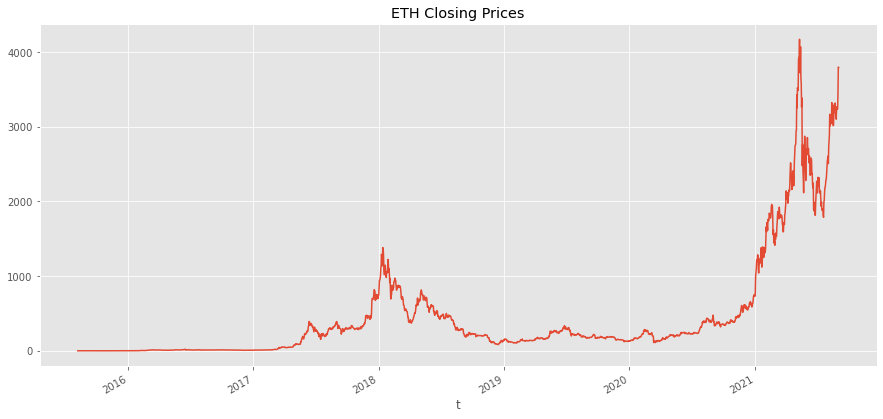

In [10]:
df['price_usd_close'].plot(figsize=(15,7), title='ETH Closing Prices');

In [11]:
# Normalizing/Scaling the Data

scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2214 entries, 2015-08-08 to 2021-09-02
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   count               2214 non-null   float64
 1   sending_count       2214 non-null   float64
 2   receiving_count     2214 non-null   float64
 3   active_count        2214 non-null   float64
 4   new_non_zero_count  2214 non-null   float64
 5   block_height        2214 non-null   float64
 6   sopr                2214 non-null   float64
 7   price_usd_close     2214 non-null   float64
 8   marketcap_usd       2214 non-null   float64
 9   difficulty_latest   2214 non-null   float64
 10  hash_rate_mean      2214 non-null   float64
dtypes: float64(11)
memory usage: 207.6 KB


### Functions for Preparing LSTM

In [2]:
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the univariate time sequence
    """
    X, y = [], []
    
    for i in range(len(seq)):
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        if out_end > len(seq):
            break
        
        seq_x, seq_y = seq[i:end], seq[end:out_end]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [3]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(12,4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(12,4))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [4]:
def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Creates a specified number of hidden layers for an RNN
    Optional: Adds regularization option - the dropout layer to prevent potential overfitting (if necessary)
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass

### Splitting the data

In [17]:
# How many periods looking back to learn
n_per_in  = 90

# How many periods to predict
n_per_out = 30

# Features (in this case it's 1 because there is only one feature: price)
n_features = 1

# Splitting the data into appropriate sequences
X, y = split_sequence(list(df.price_usd_close), n_per_in, n_per_out)

# Reshaping the X variable from 2D to 3D
X = X.reshape((X.shape[0], X.shape[1], n_features))


## Modeling - LSTM (RNN)

In [18]:
# Instatiating the model
model = Sequential()

# Activation
activ = "softsign"

# Input layer
model.add(LSTM(30, activation=activ, return_sequences=True, input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(n_layers=6, n_nodes=12, activation=activ)

# Final Hidden layer
model.add(LSTM(10, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 30)            3840      
_________________________________________________________________
lstm_1 (LSTM)                (None, 90, 12)            2064      
_________________________________________________________________
lstm_2 (LSTM)                (None, 90, 12)            1200      
_________________________________________________________________
lstm_3 (LSTM)                (None, 90, 12)            1200      
_________________________________________________________________
lstm_4 (LSTM)                (None, 90, 12)            1200      
_________________________________________________________________
lstm_5 (LSTM)                (None, 90, 12)            1200      
_________________________________________________________________
lstm_6 (LSTM)                (None, 90, 12)            1

In [19]:
# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

### Fitting and Training the RNN

In [20]:
res = model.fit(X, y, epochs=800, batch_size=32, validation_split=0.1)

Epoch 1/800
59/59 [==============================] - 14s 231ms/step - loss: 0.0042 - accuracy: 0.0249 - val_loss: 0.2242 - val_accuracy: 0.0190
Epoch 2/800
59/59 [==============================] - 12s 199ms/step - loss: 0.0016 - accuracy: 0.0265 - val_loss: 0.1631 - val_accuracy: 0.0190
Epoch 3/800
59/59 [==============================] - 12s 209ms/step - loss: 0.0012 - accuracy: 0.0260 - val_loss: 0.1478 - val_accuracy: 0.0333
Epoch 4/800
59/59 [==============================] - 15s 246ms/step - loss: 0.0010 - accuracy: 0.0255 - val_loss: 0.1436 - val_accuracy: 0.0333
Epoch 5/800
59/59 [==============================] - 14s 242ms/step - loss: 0.0010 - accuracy: 0.0398 - val_loss: 0.1486 - val_accuracy: 0.0333
Epoch 6/800
59/59 [==============================] - 12s 208ms/step - loss: 9.7578e-04 - accuracy: 0.0584 - val_loss: 0.1360 - val_accuracy: 0.0238
Epoch 7/800
59/59 [==============================] - 13s 214ms/step - loss: 8.8176e-04 - accuracy: 0.0377 - val_loss: 0.1222 - val_a

### Plotting Accuracy and Loss

In [5]:
visualize_training_results(res)

NameError: name 'res' is not defined

### Visualizing the Predictions

In [ ]:
plt.figure(figsize=(12,5))

# Getting predictions by predicting from the last available X variable
yhat = model.predict(X[-1].reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming values back to their normal prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Getting the actual values from the last available y variable which correspond to its respective X variable
actual = scaler.inverse_transform(y[-1].reshape(-1,1))

# Printing and plotting those predictions
print("Predicted Prices:\n", yhat)
plt.plot(yhat, label='Predicted')

# Printing and plotting the actual values
print("\nActual Prices:\n", actual.tolist())
plt.plot(actual.tolist(), label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
plt.savefig("BTC_validation.png")
plt.show()

### Predicting/Forecasting Future ETH Prices

In [ ]:
# Predicting off of y because it contains the most recent dates
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming the predicted values back to their original prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, index=pd.date_range(start=df.index[-1], periods=len(yhat), freq="D"), columns=df.columns)

# Printing the predicted prices
print(preds)

# Number of periods back to visualize the actual values
pers = 10

# Transforming the actual values to their original price
actual = pd.DataFrame(scaler.inverse_transform(df[["Close"]].tail(pers)), index=df.Close.tail(pers).index, columns=df.columns).append(preds.head(1))

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
plt.savefig("BTC_predictions.png")
plt.show()

In [ ]:
# Predicting off of y because it contains the most recent dates
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming the predicted values back to their original prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

In [ ]:
# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, index=pd.date_range(start=df.index[-1], periods=len(yhat), freq="D"), columns=df.columns)

# Printing the predicted prices
print(preds)

# Number of periods back to visualize the actual values
pers = 10

In [ ]:
actual.head()

In [ ]:
preds.head()